In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer

In [63]:
def cv_fit(classifier, features, target, grid=None, exhaustive=False):
    '''
    Takes an sklearn classifier, a set of feautres and their target variable for supervised learning, and optionally a 
    parameter grid, and will output the 10 fold cross validation score of the trained model. If a param grid was specified,
    the best set of parameters from a randomized grid search with 10 fold cross validation will be output using 100 iterations.
    '''
    if grid != None:
        if exhaustive:
            model = GridSearchCV(classifier, cv=10, param_grid=grid)
            model.fit(features, target)
            return model.best_score_, model.best_params_
        else:
            model = RandomizedSearchCV(classifier, cv=10, param_distributions=grid, n_iter=100)
            model.fit(features, target)
            return model.best_score_, model.best_params_
            
    else:
        model = classifier
        rkf = RepeatedKFold(n_repeats=10, n_splits=10)
        accuracies = list()
        for train_index, test_index in rkf.split(features):
            train_features = features.iloc[train_index]
            train_target = target.iloc[train_index]
            test_features = features.iloc[test_index]
            test_target = target.iloc[test_index]
            
            model.fit(train_features, train_target)
            accuracies.append(model.score(test_features, test_target))
        score = np.array(accuracies).mean()
        return score

In [294]:
def cv_perplexity(classifier, features, target):
    rkf = RepeatedKFold(n_splits=10, n_repeats=10)
    perplexities = list()
    for train_index, test_index in rkf.split(features):
        train_features = features.iloc[train_index]
        train_target = target.iloc[train_index]
        test_features = features.iloc[test_index]
        test_target = target.iloc[test_index]
        model = classifier
        model.fit(train_features, train_target)
        df = pd.DataFrame(data=model.predict_proba(test_features), columns=model.classes_)
        df['target'] = list(test_target)

        L = 0
        for i in range(len(df)):
            col = df.loc[i, 'target']
            p = df.loc[i, col]
            L += np.log(p)
        perplexities.append(np.exp(-L/len(df)))
    perplex = np.array(perplexities).mean()
    return perplex

In [37]:
npf = pd.read_csv('npf_train.csv')
npf.index = npf['date']
npf['class'] = npf['class4'].astype('category')
npf.drop(['id', 'date', 'partlybad', 'class4'], axis=1, inplace=True)

binary = npf.copy()
class2 = np.array(['event']*len(npf), dtype='object')
class2[binary['class'] == 'nonevent'] = 'nonevent'
binary['class'] = class2

scaler = StandardScaler()
scaled = scaler.fit_transform(npf.drop('class', axis=1))

npf_std = pd.DataFrame(data=scaled)
npf_std.index = npf.index
npf_std['class'] = npf['class']
npf_std.columns = npf.columns

binary_std = npf_std.copy()
binary_std['class'] = binary['class']

In [73]:
knn_feature_names = pd.read_csv('knn_binary.csv').loc[:, 'names']
naive_bayes_feature_names = pd.read_csv('nb_binary.csv').loc[:, 'names']
decision_tree_feature_names = pd.read_csv('rf_binary.csv').loc[:, 'names']
random_forest_feature_names = pd.read_csv('rf_binary.csv').loc[:, 'names']
svm_feature_names = pd.read_csv('svmLinear2_binary.csv').loc[:, 'names']
logistic_regression_feature_names = pd.read_csv('knn_binary.csv').loc[:, 'names'] #currently no explicitly defined list, so choose another
perceptron_feature_names = pd.read_csv('knn_binary.csv').loc[:, 'names'] #currently no explicitly defined list, so choose another

In [52]:
#Binary Dummy Classifier

np.random.seed(42)
model = DummyClassifier()
target = binary_std['class']
features = binary_std.drop('class', axis=1)

binary_dummy = cv_fit(model, features, target)
binary_dummy

0.44447826086956516

In [53]:
#Multiclass Dummy Classifier

np.random.seed(42)
model = DummyClassifier()
target = npf_std['class']
features = npf_std.drop('class', axis=1)

multiclass_dummy = cv_fit(model, features, target)
multiclass_dummy

0.5000338164251207

In [41]:
#Binary k-Nearest Neighbors

np.random.seed(42)
model = KNeighborsClassifier(n_jobs=-1)
target = binary_std['class']
grid = {
    'n_neighbors' : list(range(1, math.floor(0.9*(len(features)+1)))),
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : list(range(10, 101, 10)),
    'p' : [1, 2]
}

feature_accuracies = list()
feature_params = list()
for i in range(len(knn_feature_names)):
    feature_names = knn_feature_names.loc[:i]
    features = binary_std[feature_names]
    score, params = cv_fit(model, features, target, grid)
    feature_accuracies.append(score)
    feature_params.append(params)
    
binary_knn = pd.DataFrame()
binary_knn['# Features'] = list(range(1, len(knn_feature_names)+1))
binary_knn['Parameters'] = feature_params
binary_knn['Accuracy'] = feature_accuracies
binary_knn.sort_values(by='Accuracy', ascending=False, inplace=True)
binary_knn.reset_index(drop=True, inplace=True)

binary_knn.head()

,# Features,Parameters,Accuracy
0,8,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.816618
1,10,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.814396
2,7,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.812126
3,13,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.810097
4,12,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.810000


In [42]:
#Multiclass k-Nearest Neighbors

np.random.seed(42)
model = KNeighborsClassifier(n_jobs=-1)
target = npf_std['class']
grid = {
    'n_neighbors' : list(range(1, math.floor(0.9*(len(features)+1)))),
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : list(range(10, 101, 10)),
    'p' : [1, 2]
}

feature_accuracies = list()
feature_params = list()
for i in range(len(knn_feature_names)):
    feature_names = knn_feature_names.loc[:i]
    features = npf_std[feature_names]
    score, params = cv_fit(model, features, target, grid)
    feature_accuracies.append(score)
    feature_params.append(params)
    
multiclass_knn = pd.DataFrame()
multiclass_knn['# Features'] = list(range(1, len(knn_feature_names)+1))
multiclass_knn['Parameters'] = feature_params
multiclass_knn['Accuracy'] = feature_accuracies
multiclass_knn.sort_values(by='Accuracy', ascending=False, inplace=True)
multiclass_knn.reset_index(drop=True, inplace=True)

multiclass_knn.head()

,# Features,Parameters,Accuracy
0,21,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.615749
1,25,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.615652
2,7,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.615604
3,22,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.615556
4,23,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.611304


In [43]:
#Binary Gaussian Naive Bayes

np.random.seed(42)
model = GaussianNB()
target = binary_std['class']

feature_accuracies = list()
feature_params = list()
for i in range(len(naive_bayes_feature_names)):
    feature_names = naive_bayes_feature_names.loc[:i]
    features = binary_std[feature_names]
    score = cv_fit(model, features, target)
    feature_accuracies.append(score)
    
binary_naive_bayes = pd.DataFrame()
binary_naive_bayes['# Features'] = list(range(1, len(naive_bayes_feature_names)+1))
binary_naive_bayes['Accuracy'] = feature_accuracies
binary_naive_bayes.sort_values(by='Accuracy', ascending=False, inplace=True)
binary_naive_bayes.reset_index(drop=True, inplace=True)

binary_naive_bayes.head()

,# Features,Accuracy
0,7,0.784179
1,8,0.778174
2,9,0.775594
3,13,0.774029
4,14,0.770874


In [44]:
#Multiclass Gaussian Naive Bayes

np.random.seed(42)
model = GaussianNB()
target = npf_std['class']

feature_accuracies = list()
feature_params = list()
for i in range(len(naive_bayes_feature_names)):
    feature_names = naive_bayes_feature_names.loc[:i]
    features = npf_std[feature_names]
    score = cv_fit(model, features, target)
    feature_accuracies.append(score)
    
multiclass_naive_bayes = pd.DataFrame()
multiclass_naive_bayes['# Features'] = list(range(1, len(naive_bayes_feature_names)+1))
multiclass_naive_bayes['Accuracy'] = feature_accuracies
multiclass_naive_bayes.sort_values(by='Accuracy', ascending=False, inplace=True)
multiclass_naive_bayes.reset_index(drop=True, inplace=True)

multiclass_naive_bayes.head()

,# Features,Accuracy
0,4,0.552034
1,8,0.539164
2,5,0.530522
3,1,0.529324
4,2,0.525710


In [45]:
#Binary Decision Tree

np.random.seed(42)
model = DecisionTreeClassifier()
target = binary_std['class']
grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : list(range(10, 1001, 10))+[None],
    'min_samples_split' : list(range(2, 1001)),
    'min_samples_leaf' : list(range(1, 1001))
}

feature_accuracies = list()
feature_params = list()
for i in range(len(decision_tree_feature_names)):
    feature_names = decision_tree_feature_names.loc[:i]
    features = binary_std[feature_names]
    score, params = cv_fit(model, features, target, grid)
    feature_accuracies.append(score)
    feature_params.append(params)
    
binary_decision_tree = pd.DataFrame()
binary_decision_tree['# Features'] = list(range(1, len(decision_tree_feature_names)+1))
binary_decision_tree['Parameters'] = feature_params
binary_decision_tree['Accuracy'] = feature_accuracies
binary_decision_tree.sort_values(by='Accuracy', ascending=False, inplace=True)
binary_decision_tree.reset_index(drop=True, inplace=True)

binary_decision_tree.head()

,# Features,Parameters,Accuracy
0,11,"{'min_samples_split': 11, 'min_samples_leaf': ...",0.783623
1,3,"{'min_samples_split': 117, 'min_samples_leaf':...",0.755459
2,12,"{'min_samples_split': 30, 'min_samples_leaf': ...",0.753382
3,9,"{'min_samples_split': 104, 'min_samples_leaf':...",0.751014
4,7,"{'min_samples_split': 66, 'min_samples_leaf': ...",0.750725


In [46]:
#Multiclass Decision Tree

np.random.seed(42)
model = DecisionTreeClassifier()
target = npf_std['class']
grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : list(range(10, 1001, 10))+[None],
    'min_samples_split' : list(range(2, 1001)),
    'min_samples_leaf' : list(range(1, 1001))
}

feature_accuracies = list()
feature_params = list()
for i in range(len(decision_tree_feature_names)):
    feature_names = decision_tree_feature_names.loc[:i]
    features = npf_std[feature_names]
    score, params = cv_fit(model, features, target, grid)
    feature_accuracies.append(score)
    feature_params.append(params)
    
multiclass_decision_tree = pd.DataFrame()
multiclass_decision_tree['# Features'] = list(range(1, len(decision_tree_feature_names)+1))
multiclass_decision_tree['Parameters'] = feature_params
multiclass_decision_tree['Accuracy'] = feature_accuracies
multiclass_decision_tree.sort_values(by='Accuracy', ascending=False, inplace=True)
multiclass_decision_tree.reset_index(drop=True, inplace=True)

multiclass_decision_tree.head()

,# Features,Parameters,Accuracy
0,3,"{'min_samples_split': 117, 'min_samples_leaf':...",0.618019
1,16,"{'min_samples_split': 11, 'min_samples_leaf': ...",0.615459
2,12,"{'min_samples_split': 30, 'min_samples_leaf': ...",0.606763
3,9,"{'min_samples_split': 104, 'min_samples_leaf':...",0.602367
4,10,"{'min_samples_split': 93, 'min_samples_leaf': ...",0.600435


In [47]:
#Binary Random Forest

np.random.seed(42)
model = RandomForestClassifier()
target = binary_std['class']
grid = {
    'n_estimators':list(range(50, 1001, 50)),                       
    'max_features': ['auto','sqrt'], 
    'max_depth': list(range(50, 1001, 50))+[None],
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11)),
    'bootstrap': [True,False]
}

feature_accuracies = list()
feature_params = list()
for i in range(len(random_forest_feature_names)):
    feature_names = random_forest_feature_names.loc[:i]
    features = binary_std[feature_names]
    score, params = cv_fit(model, features, target, grid)
    feature_accuracies.append(score)
    feature_params.append(params)
    
binary_random_forest = pd.DataFrame()
binary_random_forest['# Features'] = list(range(1, len(decision_tree_feature_names)+1))
binary_random_forest['Parameters'] = feature_params
binary_random_forest['Accuracy'] = feature_accuracies
binary_random_forest.sort_values(by='Accuracy', ascending=False, inplace=True)
binary_random_forest.reset_index(drop=True, inplace=True)

binary_random_forest.head()

,# Features,Parameters,Accuracy
0,5,"{'n_estimators': 950, 'min_samples_split': 5, ...",0.849227
1,6,"{'n_estimators': 750, 'min_samples_split': 6, ...",0.846957
2,7,"{'n_estimators': 400, 'min_samples_split': 3, ...",0.844879
3,16,"{'n_estimators': 450, 'min_samples_split': 6, ...",0.844783
4,17,"{'n_estimators': 950, 'min_samples_split': 3, ...",0.844734


In [48]:
#Multiclass Random Forest

np.random.seed(42)
model = RandomForestClassifier()
target = npf_std['class']
grid = {
    'n_estimators':list(range(50, 1001, 50)),                       
    'max_features': ['auto','sqrt'], 
    'max_depth': list(range(50, 1001, 50))+[None],
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11)),
    'bootstrap': [True,False]
}

feature_accuracies = list()
feature_params = list()
for i in range(len(random_forest_feature_names)):
    feature_names = random_forest_feature_names.loc[:i]
    features = npf_std[feature_names]
    score, params = cv_fit(model, features, target, grid)
    feature_accuracies.append(score)
    feature_params.append(params)
    
multiclass_random_forest = pd.DataFrame()
multiclass_random_forest['# Features'] = list(range(1, len(decision_tree_feature_names)+1))
multiclass_random_forest['Parameters'] = feature_params
multiclass_random_forest['Accuracy'] = feature_accuracies
multiclass_random_forest.sort_values(by='Accuracy', ascending=False, inplace=True)
multiclass_random_forest.reset_index(drop=True, inplace=True)

multiclass_random_forest.head()

,# Features,Parameters,Accuracy
0,3,"{'n_estimators': 50, 'min_samples_split': 8, '...",0.652947
1,5,"{'n_estimators': 750, 'min_samples_split': 2, ...",0.646039
2,19,"{'n_estimators': 350, 'min_samples_split': 5, ...",0.641739
3,24,"{'n_estimators': 550, 'min_samples_split': 9, ...",0.639614
4,12,"{'n_estimators': 350, 'min_samples_split': 2, ...",0.639614


In [49]:
#Binary SVM
np.random.seed(42)
model = SVC(kernel='rbf')
target = binary_std['class']
grid = {
    'C' : list(range(1, 11)),
    'gamma' : ['scale', 'auto'],
    'coef0' : list(range(10)),
    'shrinking' : [True, False]
}

feature_accuracies = list()
feature_params = list()
for i in range(len(svm_feature_names)):
    feature_names = svm_feature_names.loc[:i]
    features = binary_std[feature_names]
    score, params = cv_fit(model, features, target, grid)
    feature_accuracies.append(score)
    feature_params.append(params)
    
binary_svm = pd.DataFrame()
binary_svm['# Features'] = list(range(1, len(svm_feature_names)+1))
binary_svm['Parameters'] = feature_params
binary_svm['Accuracy'] = feature_accuracies
binary_svm.sort_values(by='Accuracy', ascending=False, inplace=True)
binary_svm.reset_index(drop=True, inplace=True)

binary_svm.head()

,# Features,Parameters,Accuracy
0,9,"{'shrinking': True, 'gamma': 'auto', 'coef0': ...",0.840483
1,12,"{'shrinking': True, 'gamma': 'scale', 'coef0':...",0.838502
2,11,"{'shrinking': False, 'gamma': 'scale', 'coef0'...",0.838309
3,7,"{'shrinking': False, 'gamma': 'scale', 'coef0'...",0.835894
4,10,"{'shrinking': False, 'gamma': 'auto', 'coef0':...",0.833816


In [50]:
#Multiclass SVM

np.random.seed(42)
model = SVC(kernel='rbf')
target = npf_std['class']
grid = {
    'C' : list(range(1, 11)),
    'gamma' : ['scale', 'auto'],
    'coef0' : list(range(10)),
    'shrinking' : [True, False]
}

feature_accuracies = list()
feature_params = list()
for i in range(len(svm_feature_names)):
    feature_names = svm_feature_names.loc[:i]
    features = npf_std[feature_names]
    score, params = cv_fit(model, features, target, grid)
    feature_accuracies.append(score)
    feature_params.append(params)
    
multiclass_svm = pd.DataFrame()
multiclass_svm['# Features'] = list(range(1, len(svm_feature_names)+1))
multiclass_svm['Parameters'] = feature_params
multiclass_svm['Accuracy'] = feature_accuracies
multiclass_svm.sort_values(by='Accuracy', ascending=False, inplace=True)
multiclass_svm.reset_index(drop=True, inplace=True)

multiclass_svm.head()

,# Features,Parameters,Accuracy
0,11,"{'shrinking': True, 'gamma': 'auto', 'coef0': ...",0.635459
1,12,"{'shrinking': True, 'gamma': 'auto', 'coef0': ...",0.633237
2,15,"{'shrinking': True, 'gamma': 'auto', 'coef0': ...",0.633188
3,14,"{'shrinking': True, 'gamma': 'scale', 'coef0':...",0.633092
4,16,"{'shrinking': False, 'gamma': 'auto', 'coef0':...",0.631014


In [65]:
#Binary Logistic Regression
np.random.seed(42)
model = LogisticRegression(n_jobs=-1)
target = binary_std['class']
grid = {
    'C' : list(range(1, 11)),
    'fit_intercept' : [True, False],
}

feature_accuracies = list()
feature_params = list()
for i in range(len(logistic_regression_feature_names)):
    feature_names = logistic_regression_feature_names.loc[:i]
    features = binary_std[feature_names]
    score, params = cv_fit(model, features, target, grid, exhaustive=True)
    feature_accuracies.append(score)
    feature_params.append(params)
    
binary_logistic_regression = pd.DataFrame()
binary_logistic_regression['# Features'] = list(range(1, len(logistic_regression_feature_names)+1))
binary_logistic_regression['Parameters'] = feature_params
binary_logistic_regression['Accuracy'] = feature_accuracies
binary_logistic_regression.sort_values(by='Accuracy', ascending=False, inplace=True)
binary_logistic_regression.reset_index(drop=True, inplace=True)

binary_logistic_regression.head()

,# Features,Parameters,Accuracy
0,20,"{'C': 6, 'fit_intercept': True}",0.829420
1,17,"{'C': 2, 'fit_intercept': False}",0.825266
2,7,"{'C': 3, 'fit_intercept': True}",0.825217
3,25,"{'C': 7, 'fit_intercept': True}",0.824976
4,9,"{'C': 2, 'fit_intercept': True}",0.822995


In [66]:
#Multiclass Logistic Regression
np.random.seed(42)
model = LogisticRegression(n_jobs=-1)
target = npf_std['class']
grid = {
    'C' : list(range(1, 11)),
    'fit_intercept' : [True, False],
}

feature_accuracies = list()
feature_params = list()
for i in range(len(logistic_regression_feature_names)):
    feature_names = logistic_regression_feature_names.loc[:i]
    features = npf_std[feature_names]
    score, params = cv_fit(model, features, target, grid, exhaustive=True)
    feature_accuracies.append(score)
    feature_params.append(params)
    
multiclass_logistic_regression = pd.DataFrame()
multiclass_logistic_regression['# Features'] = list(range(1, len(logistic_regression_feature_names)+1))
multiclass_logistic_regression['Parameters'] = feature_params
multiclass_logistic_regression['Accuracy'] = feature_accuracies
multiclass_logistic_regression.sort_values(by='Accuracy', ascending=False, inplace=True)
multiclass_logistic_regression.reset_index(drop=True, inplace=True)

multiclass_logistic_regression.head()

,# Features,Parameters,Accuracy
0,9,"{'C': 10, 'fit_intercept': True}",0.626473
1,20,"{'C': 1, 'fit_intercept': True}",0.624348
2,19,"{'C': 1, 'fit_intercept': True}",0.622126
3,10,"{'C': 3, 'fit_intercept': True}",0.619952
4,16,"{'C': 3, 'fit_intercept': True}",0.619903


In [71]:
#Binary Gaussian Naive Bayes
np.random.seed(42)
model = GaussianNB()
target = binary_std['class']

feature_accuracies = list()
feature_params = list()
for i in range(len(naive_bayes_feature_names)):
    feature_names = naive_bayes_feature_names.loc[:i]
    features = binary_std[feature_names]
    score = cv_fit(model, features, target)
    feature_accuracies.append(score)
    feature_params.append(params)
    
binary_naive_bayes = pd.DataFrame()
binary_naive_bayes['# Features'] = list(range(1, len(naive_bayes_feature_names)+1))
binary_naive_bayes['Accuracy'] = feature_accuracies
binary_naive_bayes.sort_values(by='Accuracy', ascending=False, inplace=True)
binary_naive_bayes.reset_index(drop=True, inplace=True)

binary_naive_bayes.head()

,# Features,Accuracy
0,7,0.784179
1,8,0.778174
2,9,0.775594
3,13,0.774029
4,14,0.770874


In [70]:
#Multiclass Gaussian Naive Bayes
np.random.seed(42)
model = GaussianNB()
target = npf_std['class']

feature_accuracies = list()
feature_params = list()
for i in range(len(naive_bayes_feature_names)):
    feature_names = naive_bayes_feature_names.loc[:i]
    features = npf_std[feature_names]
    score = cv_fit(model, features, target)
    feature_accuracies.append(score)
    feature_params.append(params)
    
multiclass_naive_bayes = pd.DataFrame()
multiclass_naive_bayes['# Features'] = list(range(1, len(naive_bayes_feature_names)+1))
multiclass_naive_bayes['Accuracy'] = feature_accuracies
multiclass_naive_bayes.sort_values(by='Accuracy', ascending=False, inplace=True)
multiclass_naive_bayes.reset_index(drop=True, inplace=True)

multiclass_naive_bayes.head()

,# Features,Accuracy
0,4,0.552034
1,8,0.539164
2,5,0.530522
3,1,0.529324
4,2,0.525710


In [77]:
#Binary Perceptron
np.random.seed(42)

features1 = binary_std.drop('class', axis=1)
target = binary_std['class']

rkf = RepeatedKFold(n_splits=10, n_repeats=10)

feature_accuracies = list()
for i in range(len(perceptron_feature_names)):
    accuracies = list()
    feature_names = perceptron_feature_names.loc[:i]
    features = features1[feature_names]
    for train_index, test_index in rkf.split(features):
        features_train = features.iloc[train_index]
        features_test = features.iloc[test_index]
        target_train = target.iloc[train_index]
        target_test = target.iloc[test_index]

        model = Perceptron()
        model.fit(features_train, target_train)
        accuracies.append(model.score(features_test, target_test))

    feature_accuracies.append(np.array(accuracies).mean())
    
binary_perceptron = pd.DataFrame()
binary_perceptron['# Features'] = list(range(1, len(perceptron_feature_names)+1))
binary_perceptron['Accuracy'] = feature_accuracies
binary_perceptron.sort_values(by='Accuracy', ascending=False, inplace=True)
binary_perceptron.reset_index(drop=True, inplace=True)

binary_perceptron.head()

,# Features,Accuracy
0,9,0.805700
1,19,0.794638
2,16,0.789952
3,25,0.783913
4,24,0.775072


In [93]:
#Chained Binary Perceptron

features1 = npf_std.drop('class', axis=1)
target = npf_std['class']

rkf = RepeatedKFold(n_splits=10, n_repeats=10)

feature_accuracies = list()
for i in range(len(perceptron_feature_names)):
    accuracies = list()
    feature_names = list(perceptron_feature_names.loc[:i])
    cbp = npf_std[feature_names+['class']]
    for train_index, test_index in rkf.split(cbp):
        train = cbp.iloc[train_index]
        test = cbp.iloc[test_index]

        EvNE_train = train.copy()
        temp = np.array(['event']*len(EvNE_train), dtype='object')
        temp[EvNE_train['class'] == 'nonevent'] = 'nonevent'
        EvNE_train['class'] = temp

        IvII_train = train.copy()
        IvII_train = IvII_train[IvII_train['class'] != 'nonevent']
        temp = np.array(['Type I']*len(IvII_train), dtype='object')
        temp[IvII_train['class'] == 'II'] = 'II'
        IvII_train['class'] = temp

        AvB_train = train.copy()
        AvB_train = AvB_train[(AvB_train['class'] == 'Ia') | (AvB_train['class'] == 'Ib')]
        temp = np.array(['Ia']*len(AvB_train), dtype='object')
        temp[AvB_train['class'] == 'Ib'] = 'Ib'
        AvB_train['class'] = temp

        EvNE_model = Perceptron()
        IvII_model = Perceptron()
        AvB_model = Perceptron()
        EvNE_model.fit(EvNE_train.drop('class', axis=1), EvNE_train['class'])
        IvII_model.fit(IvII_train.drop('class', axis=1), IvII_train['class'])
        AvB_model.fit(AvB_train.drop('class', axis=1), AvB_train['class'])

        predictions = list()
        features_test = test.drop('class', axis=1)
        target_test = test['class']
        for date in test.index:
            entry = features_test.loc[date]
            pred = EvNE_model.predict([entry]) #Compare Event vs Nonevent
            if pred == 'nonevent':
                predictions.append(pred[0])
            else:
                pred = IvII_model.predict([entry]) #Compare Type I vs Type II
                if pred == 'Type II':
                    predictions.append(pred[0])
                else:
                    pred = AvB_model.predict([entry]) #Compare Type Ia vs Type Ib
                    predictions.append(pred[0])
        predictions = np.array(predictions)            
        correct_arr = (target_test == predictions).values
        correct = len(predictions[correct_arr])
        accuracies.append(correct/len(predictions))
    feature_accuracies.append(np.array(accuracies).mean())
    
chained_perceptron = pd.DataFrame()
chained_perceptron['# Features'] = list(range(1, len(perceptron_feature_names)+1))
chained_perceptron['Accuracy'] = feature_accuracies
chained_perceptron.sort_values(by='Accuracy', ascending=False, inplace=True)
chained_perceptron.reset_index(drop=True, inplace=True)

chained_perceptron.head()

,# Features,Accuracy
0,20,0.527077
1,19,0.519594
2,23,0.518082
3,25,0.517348
4,22,0.517005


In [118]:
binary_models = {
    'kNN' : binary_knn,
    'Decision Tree' : binary_decision_tree,
    'Random Forest' : binary_random_forest,
    'SVM' : binary_svm,
    'Naive Bayes' : binary_naive_bayes,
    'Logistic Regression' : binary_logistic_regression,
    'Perceptron' : binary_perceptron
}

multiclass_models = {
    'kNN' : multiclass_knn,
    'Decision Tree' : multiclass_decision_tree,
    'Random Forest' : multiclass_random_forest,
    'SVM' : multiclass_svm,
    'Naive Bayes' : multiclass_naive_bayes,
    'Logistic Regression' : multiclass_logistic_regression,
    'Perceptron' : chained_perceptron
}

<Figure size 432x288 with 0 Axes>

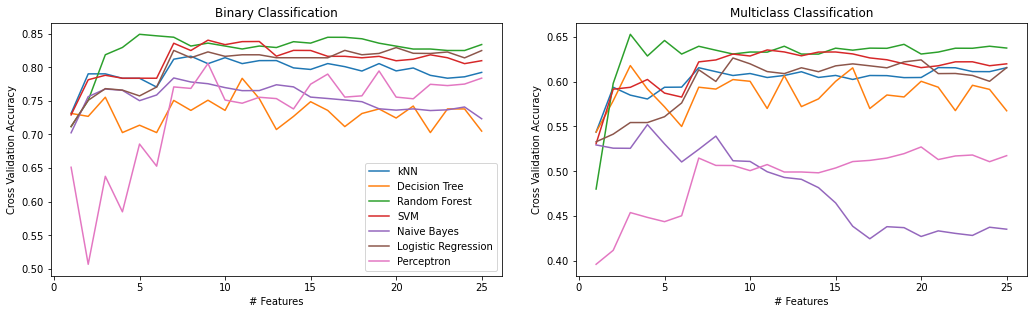

In [166]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for model in binary_models.keys():
    sns.lineplot(data=binary_models[model], x='# Features', y='Accuracy', ax=ax[0], label=model)
    sns.lineplot(data=multiclass_models[model], x='# Features', y='Accuracy', ax=ax[1])
ax[0].legend()
ax[0].set_title('Binary Classification') 
ax[0].set_ylabel('Cross Validation Accuracy')
ax[1].set_title('Multiclass Classification') 
ax[1].set_ylabel('Cross Validation Accuracy')
fig.tight_layout(pad=3)
plt.show()

<Figure size 432x288 with 0 Axes>

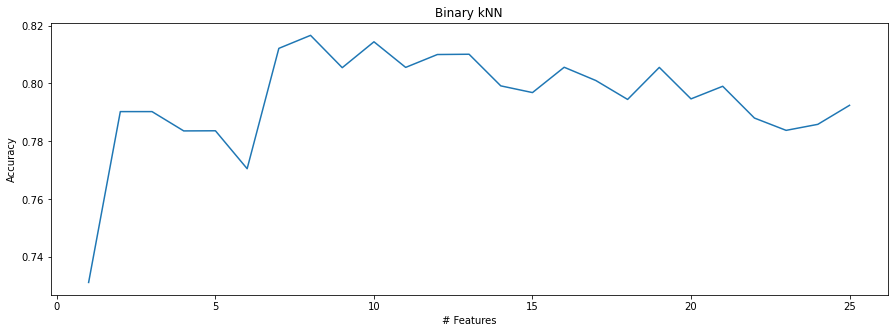

<Figure size 432x288 with 0 Axes>

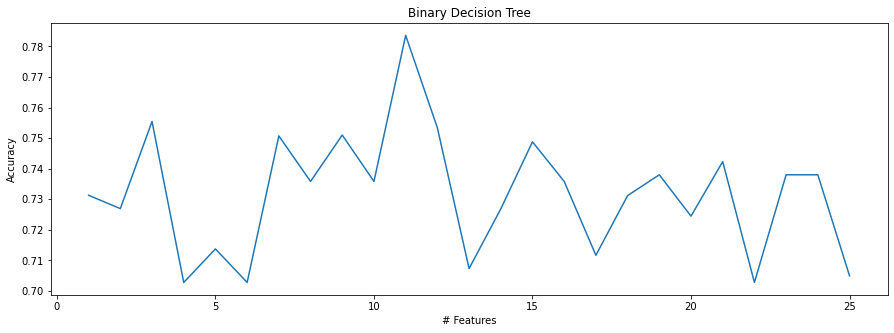

<Figure size 432x288 with 0 Axes>

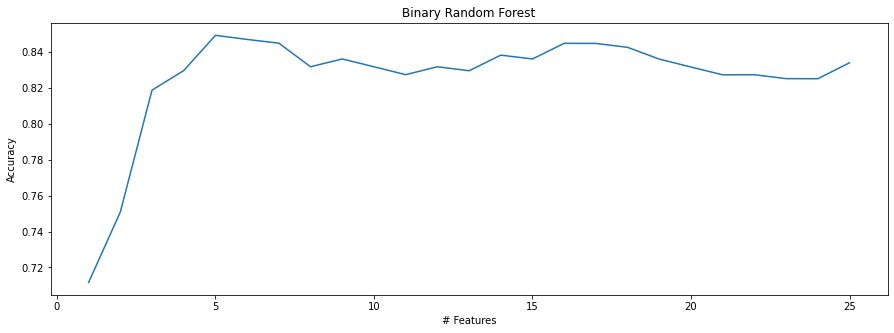

<Figure size 432x288 with 0 Axes>

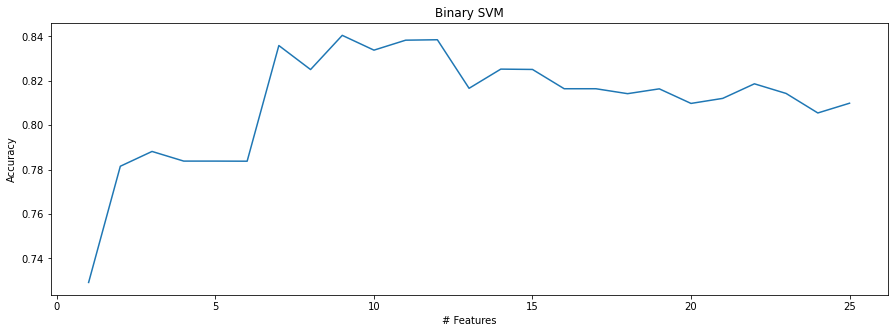

<Figure size 432x288 with 0 Axes>

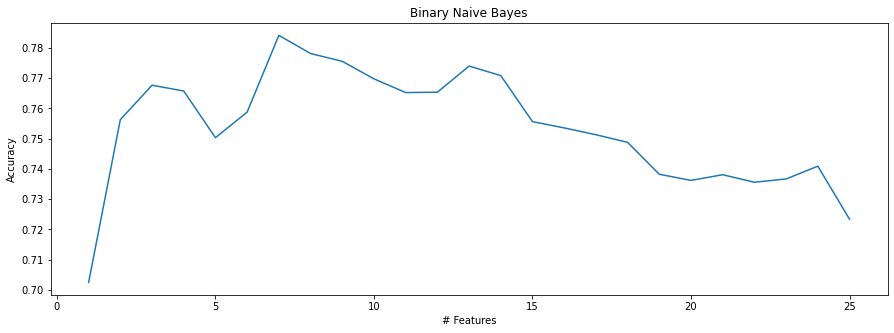

<Figure size 432x288 with 0 Axes>

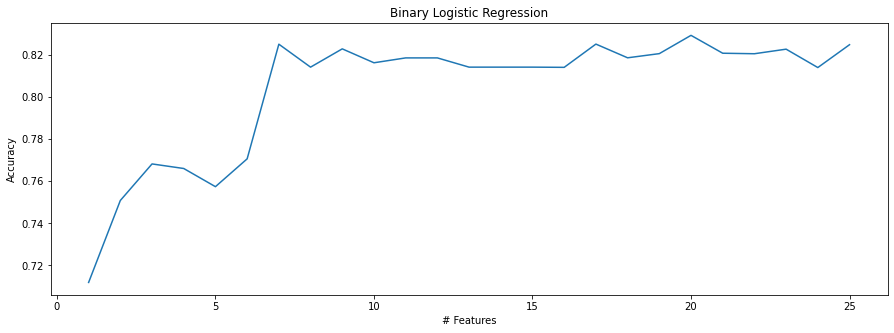

<Figure size 432x288 with 0 Axes>

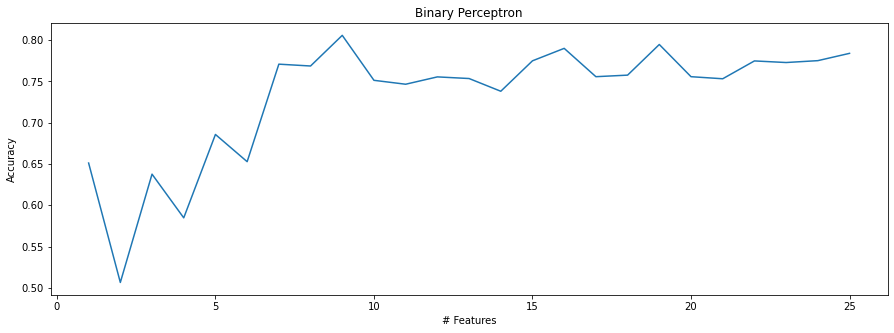

<Figure size 432x288 with 0 Axes>

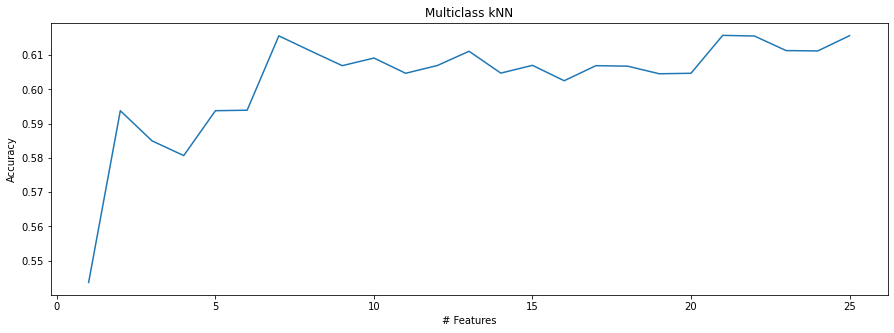

<Figure size 432x288 with 0 Axes>

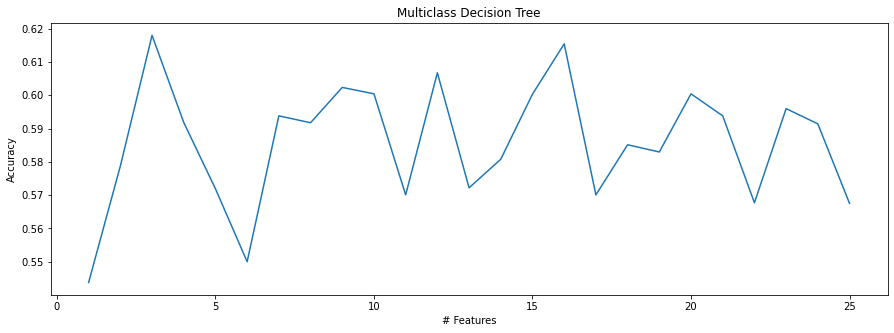

<Figure size 432x288 with 0 Axes>

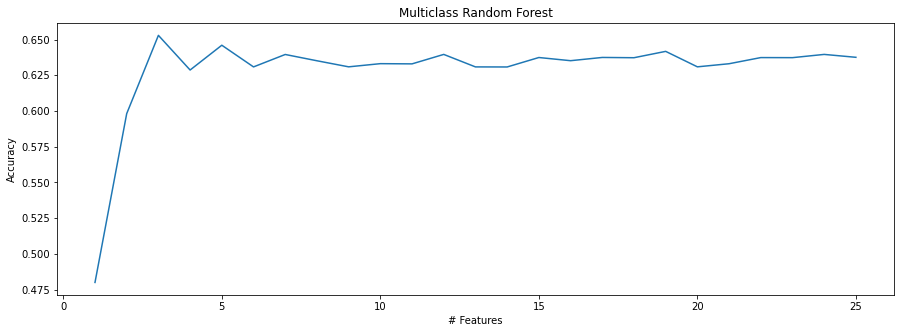

<Figure size 432x288 with 0 Axes>

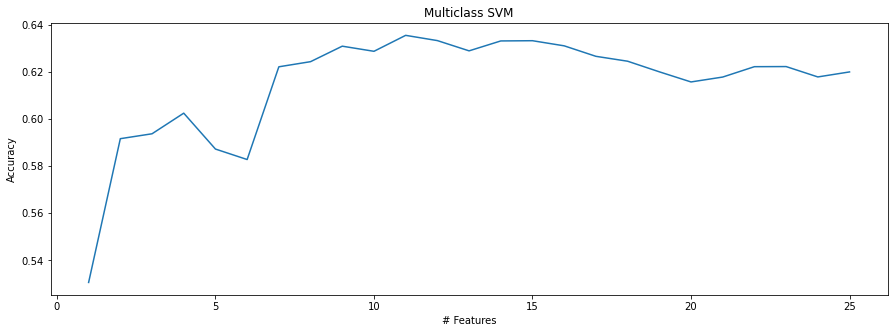

<Figure size 432x288 with 0 Axes>

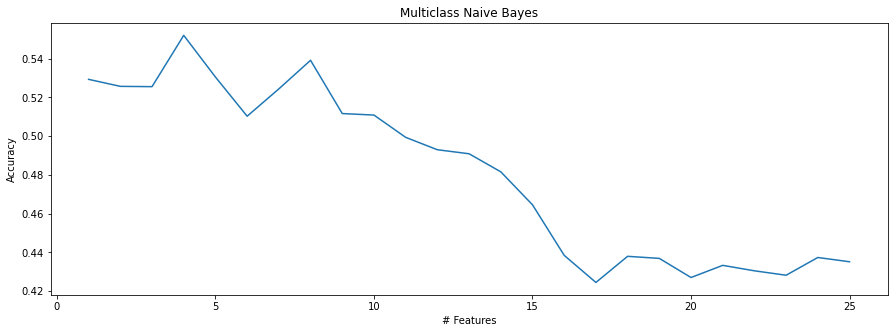

<Figure size 432x288 with 0 Axes>

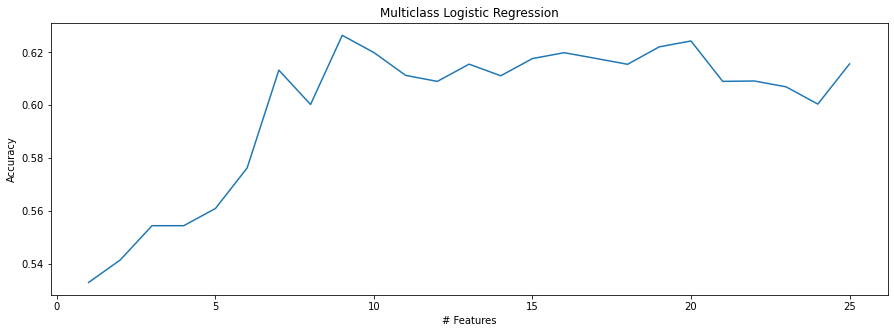

<Figure size 432x288 with 0 Axes>

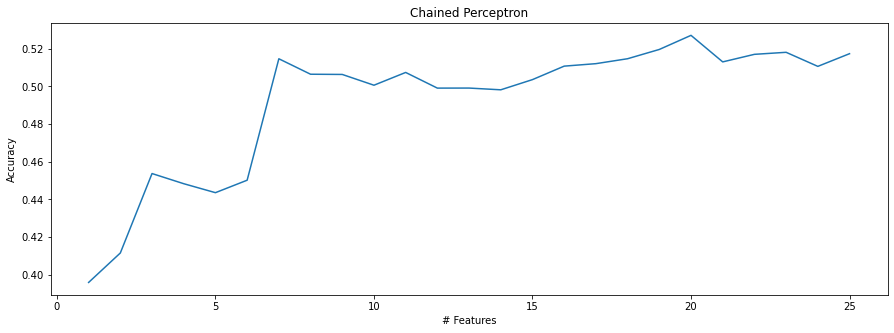

In [137]:
for model in binary_models.keys():
    plt.clf()
    plt.figure(figsize=(15,5))
    sns.lineplot(data=binary_models[model], x='# Features', y='Accuracy')
    plt.title('Binary ' + model)
    plt.show()
for model in multiclass_models.keys():
    plt.clf()
    plt.figure(figsize=(15,5))
    sns.lineplot(data=multiclass_models[model], x='# Features', y='Accuracy')
    if model != 'Perceptron':
        plt.title('Multiclass ' + model)
    else:
        plt.title('Chained ' + model)
    plt.show()

<Figure size 432x288 with 0 Axes>

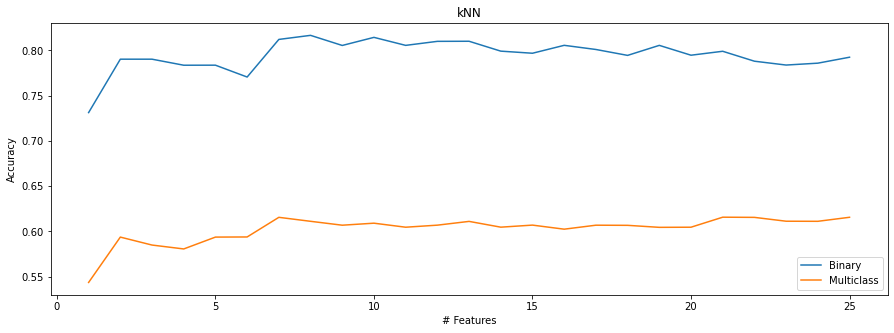

<Figure size 432x288 with 0 Axes>

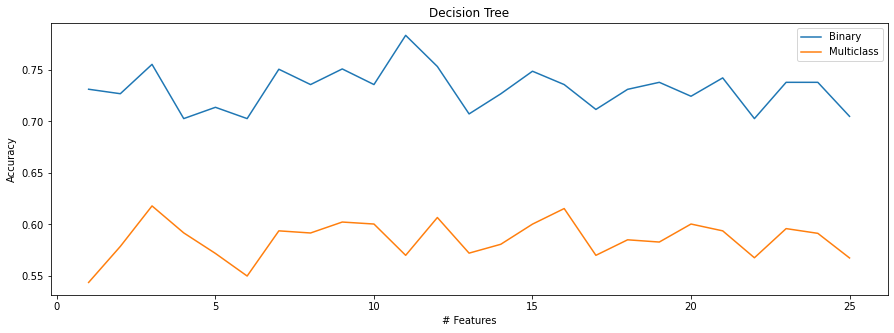

<Figure size 432x288 with 0 Axes>

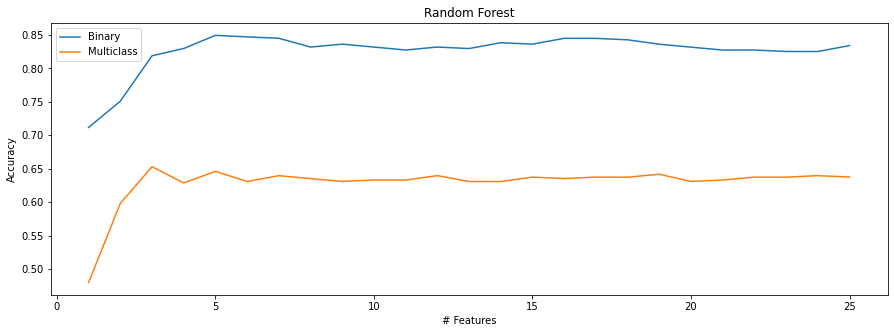

<Figure size 432x288 with 0 Axes>

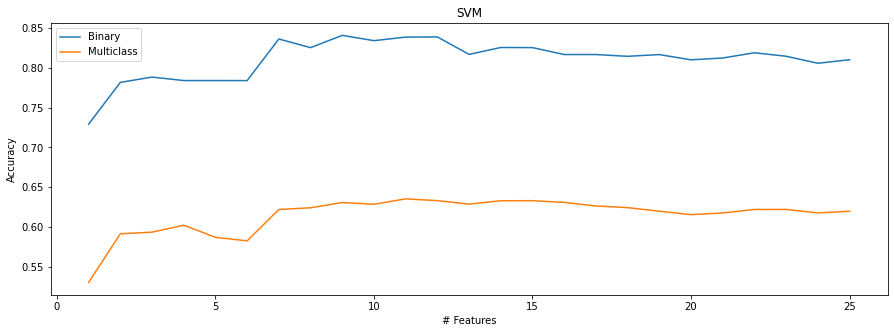

<Figure size 432x288 with 0 Axes>

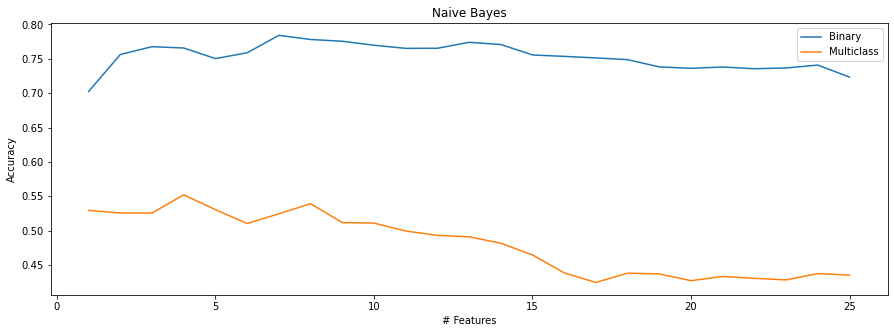

<Figure size 432x288 with 0 Axes>

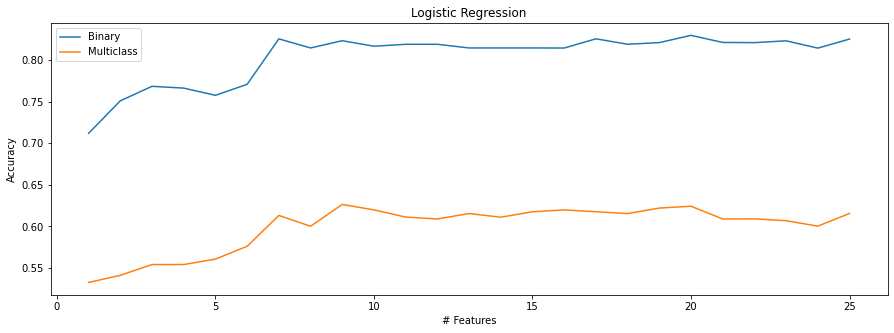

<Figure size 432x288 with 0 Axes>

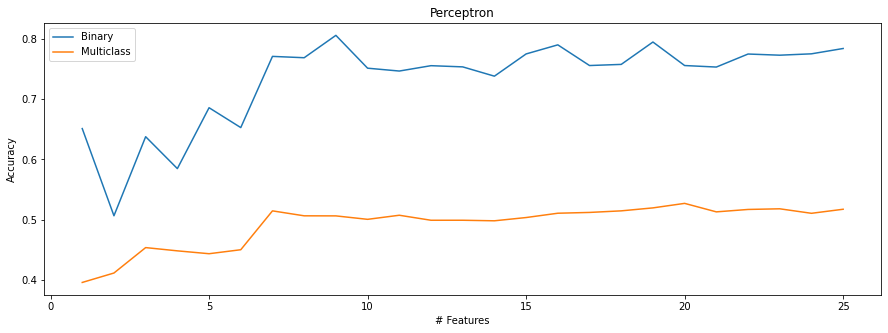

In [140]:
for model in binary_models.keys():
    plt.clf()
    plt.figure(figsize=(15,5))
    sns.lineplot(data=binary_models[model], x='# Features', y='Accuracy', label='Binary')
    sns.lineplot(data=multiclass_models[model], x='# Features', y='Accuracy', label='Multiclass')
    plt.title(model)
    plt.show()

In [164]:
binary_table = pd.DataFrame()
accuracies = list()
for model in binary_models.keys():
    accuracies.append(binary_models[model].loc[0, 'Accuracy'])
binary_table['Accuracy'] = accuracies
binary_table.index=binary_models.keys()
binary_table.index.name = 'Model'
binary_table.loc['Dummy'] = binary_dummy
binary_table.sort_values(by='Accuracy', ascending=False, inplace=True)

multiclass_table = pd.DataFrame()
accuracies = list()
for model in multiclass_models.keys():
    accuracies.append(multiclass_models[model].loc[0, 'Accuracy'])
multiclass_table['Accuracy'] = accuracies
multiclass_table.index=multiclass_models.keys()
multiclass_table.index.name = 'Model'
multiclass_table.loc['Dummy'] = multiclass_dummy
multiclass_table.sort_values(by='Accuracy', ascending=False, inplace=True)

accuracy_table = binary_table.copy()
accuracy_table.drop('Accuracy', axis=1, inplace=True)
accuracy_table['Binary Accuracy'] = binary_table['Accuracy']
accuracy_table['Multiclass Accuracy'] = multiclass_table['Accuracy']
accuracy_table

,Binary Accuracy,Multiclass Accuracy
Model,,
Random Forest,0.849227,0.652947
SVM,0.840483,0.635459
Logistic Regression,0.829420,0.626473
kNN,0.816618,0.615749
Perceptron,0.805700,0.527077
Naive Bayes,0.784179,0.552034
Decision Tree,0.783623,0.618019
Dummy,0.444478,0.500034


In [342]:
#Binary Dummy

np.random.seed(42)
model = DummyClassifier()
target = binary_std['class']
features = binary_std.drop('class', axis=1)
binary_dummy_perplexity = cv_perplexity(model, features, target)
binary_dummy_perplexity

2.004788774748057

In [343]:
#Multiclass Dummy

np.random.seed(42)
model = DummyClassifier()
target = npf_std['class']
features = npf_std.drop('class', axis=1)
multiclass_dummy_perplexity = cv_perplexity(model, features, target)
multiclass_dummy_perplexity

3.289050713843734

In [315]:
#Binary k-Nearest Neighbors

np.random.seed(42)
target = binary_std['class']

feature_perplexity = list()
for i in range(len(knn_feature_names)):
    params = binary_knn[binary_knn['# Features'] == i+1].iloc[0, 1]
    model = KNeighborsClassifier(**params)
    feature_names = knn_feature_names.loc[:i]
    features = binary_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

binary_knn_perplexity = pd.DataFrame()
binary_knn_perplexity['# Features'] = list(range(1, len(knn_feature_names)+1))
binary_knn_perplexity['Perplexity'] = feature_perplexity
binary_knn_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
binary_knn_perplexity.reset_index(drop=True, inplace=True)

binary_knn_perplexity.head()

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

,# Features,Perplexity
0,7,1.515652
1,9,1.534970
2,25,1.558309
3,23,1.565269
4,2,1.741902


In [316]:
#Multiclass k-Nearest Neighbors

np.random.seed(42)
target = npf_std['class']

feature_perplexity = list()
for i in range(len(knn_feature_names)):
    params = multiclass_knn[multiclass_knn['# Features'] == i+1].iloc[0, 1]
    model = KNeighborsClassifier(**params)
    feature_names = knn_feature_names.loc[:i]
    features = npf_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

multiclass_knn_perplexity = pd.DataFrame()
multiclass_knn_perplexity['# Features'] = list(range(1, len(knn_feature_names)+1))
multiclass_knn_perplexity['Perplexity'] = feature_perplexity
multiclass_knn_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
multiclass_knn_perplexity.reset_index(drop=True, inplace=True)

multiclass_knn_perplexity.head()

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

,# Features,Perplexity
0,20,2.628204
1,3,2.694114
2,6,2.713791
3,5,2.718482
4,17,2.724155


In [320]:
#Binary Gaussian Naive Bayes

np.random.seed(42)
target = binary_std['class']

feature_perplexity = list()
for i in range(len(naive_bayes_feature_names)):
    model = GaussianNB()
    feature_names = naive_bayes_feature_names.loc[:i]
    features = binary_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

binary_naive_bayes_perplexity = pd.DataFrame()
binary_naive_bayes_perplexity['# Features'] = list(range(1, len(naive_bayes_feature_names)+1))
binary_naive_bayes_perplexity['Perplexity'] = feature_perplexity
binary_naive_bayes_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
binary_naive_bayes_perplexity.reset_index(drop=True, inplace=True)

binary_naive_bayes_perplexity.head()

,# Features,Perplexity
0,1,1.763974
1,2,1.793002
2,3,1.806876
3,4,2.016957
4,5,2.191090


In [321]:
#Multiclass Gaussian Naive Bayes

np.random.seed(42)
target = npf_std['class']

feature_perplexity = list()
for i in range(len(naive_bayes_feature_names)):
    model = GaussianNB()
    feature_names = naive_bayes_feature_names.loc[:i]
    features = npf_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

multiclass_naive_bayes_perplexity = pd.DataFrame()
multiclass_naive_bayes_perplexity['# Features'] = list(range(1, len(naive_bayes_feature_names)+1))
multiclass_naive_bayes_perplexity['Perplexity'] = feature_perplexity
multiclass_naive_bayes_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
multiclass_naive_bayes_perplexity.reset_index(drop=True, inplace=True)

multiclass_naive_bayes_perplexity.head()

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

,# Features,Perplexity
0,1,2.889792
1,2,3.035383
2,3,3.111117
3,4,3.521252
4,5,3.871338


In [324]:
#Binary Logistic Regression

np.random.seed(42)
target = binary_std['class']

feature_perplexity = list()
for i in range(len(logistic_regression_feature_names)):
    params = binary_logistic_regression[binary_logistic_regression['# Features'] == i+1].iloc[0, 1]
    model = LogisticRegression(**params)
    feature_names = logistic_regression_feature_names.loc[:i]
    features = binary_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

binary_logistic_regression_perplexity = pd.DataFrame()
binary_logistic_regression_perplexity['# Features'] = list(range(1, len(logistic_regression_feature_names)+1))
binary_logistic_regression_perplexity['Perplexity'] = feature_perplexity
binary_logistic_regression_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
binary_logistic_regression_perplexity.reset_index(drop=True, inplace=True)

binary_logistic_regression_perplexity.head()

,# Features,Perplexity
0,9,1.485248
1,10,1.486600
2,12,1.489682
3,11,1.492331
4,14,1.493937


In [325]:
#Multiclass Logistic Regression

np.random.seed(42)
target = npf_std['class']

feature_perplexity = list()
for i in range(len(logistic_regression_feature_names)):
    params = multiclass_logistic_regression[multiclass_logistic_regression['# Features'] == i+1].iloc[0, 1]
    model = LogisticRegression(**params)
    feature_names = logistic_regression_feature_names.loc[:i]
    features = npf_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

multiclass_logistic_regression_perplexity = pd.DataFrame()
multiclass_logistic_regression_perplexity['# Features'] = list(range(1, len(logistic_regression_feature_names)+1))
multiclass_logistic_regression_perplexity['Perplexity'] = feature_perplexity
multiclass_logistic_regression_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
multiclass_logistic_regression_perplexity.reset_index(drop=True, inplace=True)

multiclass_logistic_regression_perplexity.head()

,# Features,Perplexity
0,8,2.490400
1,7,2.495474
2,10,2.509653
3,11,2.512744
4,9,2.528521


In [327]:
#Binary SVM

np.random.seed(42)
target = binary_std['class']

feature_perplexity = list()
for i in range(len(svm_feature_names)):
    params = binary_svm[binary_svm['# Features'] == i+1].iloc[0, 1]
    model = SVC(**params, probability=True)
    feature_names = svm_feature_names.loc[:i]
    features = binary_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

binary_svm_perplexity = pd.DataFrame()
binary_svm_perplexity['# Features'] = list(range(1, len(svm_feature_names)+1))
binary_svm_perplexity['Perplexity'] = feature_perplexity
binary_svm_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
binary_svm_perplexity.reset_index(drop=True, inplace=True)

binary_svm_perplexity.head()

,# Features,Perplexity
0,11,1.449077
1,10,1.457200
2,7,1.462425
3,25,1.462878
4,9,1.469221


In [328]:
#Multiclass SVM

np.random.seed(42)
target = npf_std['class']

feature_perplexity = list()
for i in range(len(svm_feature_names)):
    params = multiclass_svm[multiclass_svm['# Features'] == i+1].iloc[0, 1]
    model = SVC(**params, probability=True)
    feature_names = svm_feature_names.loc[:i]
    features = npf_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

multiclass_svm_perplexity = pd.DataFrame()
multiclass_svm_perplexity['# Features'] = list(range(1, len(svm_feature_names)+1))
multiclass_svm_perplexity['Perplexity'] = feature_perplexity
multiclass_svm_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
multiclass_svm_perplexity.reset_index(drop=True, inplace=True)

multiclass_svm_perplexity.head()

,# Features,Perplexity
0,10,2.359888
1,11,2.385298
2,13,2.387119
3,12,2.388308
4,15,2.393504


In [329]:
#Binary Decision Tree

np.random.seed(42)
target = binary_std['class']

feature_perplexity = list()
for i in range(len(decision_tree_feature_names)):
    params = binary_decision_tree[binary_decision_tree['# Features'] == i+1].iloc[0, 1]
    model = DecisionTreeClassifier(**params)
    feature_names = decision_tree_feature_names.loc[:i]
    features = binary_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

binary_decision_tree_perplexity = pd.DataFrame()
binary_decision_tree_perplexity['# Features'] = list(range(1, len(decision_tree_feature_names)+1))
binary_decision_tree_perplexity['Perplexity'] = feature_perplexity
binary_decision_tree_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
binary_decision_tree_perplexity.reset_index(drop=True, inplace=True)

binary_decision_tree_perplexity.head()

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

,# Features,Perplexity
0,10,1.702050
1,20,1.715706
2,8,1.737605
3,18,1.741480
4,4,1.745545


In [330]:
#Multiclass Decision Tree

np.random.seed(42)
target = npf_std['class']

feature_perplexity = list()
for i in range(len(decision_tree_feature_names)):
    params = multiclass_decision_tree[multiclass_decision_tree['# Features'] == i+1].iloc[0, 1]
    model = DecisionTreeClassifier(**params)
    feature_names = decision_tree_feature_names.loc[:i]
    features = npf_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

multiclass_decision_tree_perplexity = pd.DataFrame()
multiclass_decision_tree_perplexity['# Features'] = list(range(1, len(decision_tree_feature_names)+1))
multiclass_decision_tree_perplexity['Perplexity'] = feature_perplexity
multiclass_decision_tree_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
multiclass_decision_tree_perplexity.reset_index(drop=True, inplace=True)

multiclass_decision_tree_perplexity.head()

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

,# Features,Perplexity
0,4,2.799274
1,2,2.806044
2,1,2.943012
3,23,inf
4,22,inf


In [331]:
#Binary Random Forest

np.random.seed(42)
target = binary_std['class']

feature_perplexity = list()
for i in range(len(random_forest_feature_names)):
    params = binary_random_forest[binary_random_forest['# Features'] == i+1].iloc[0, 1]
    model = RandomForestClassifier(**params)
    feature_names = random_forest_feature_names.loc[:i]
    features = binary_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

binary_random_forest_perplexity = pd.DataFrame()
binary_random_forest_perplexity['# Features'] = list(range(1, len(random_forest_feature_names)+1))
binary_random_forest_perplexity['Perplexity'] = feature_perplexity
binary_random_forest_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
binary_random_forest_perplexity.reset_index(drop=True, inplace=True)

binary_random_forest_perplexity.head()

,# Features,Perplexity
0,12,1.430907
1,16,1.440648
2,15,1.442636
3,13,1.443319
4,17,1.446725


In [332]:
#Multiclass Random Forest

np.random.seed(42)
target = npf_std['class']

feature_perplexity = list()
for i in range(len(random_forest_feature_names)):
    params = multiclass_random_forest[multiclass_random_forest['# Features'] == i+1].iloc[0, 1]
    model = RandomForestClassifier(**params)
    feature_names = random_forest_feature_names.loc[:i]
    features = npf_std[feature_names]
    feature_perplexity.append(cv_perplexity(model, features, target))

multiclass_random_forest_perplexity = pd.DataFrame()
multiclass_random_forest_perplexity['# Features'] = list(range(1, len(random_forest_feature_names)+1))
multiclass_random_forest_perplexity['Perplexity'] = feature_perplexity
multiclass_random_forest_perplexity.sort_values(by='Perplexity', ascending=True, inplace=True)
multiclass_random_forest_perplexity.reset_index(drop=True, inplace=True)

multiclass_random_forest_perplexity.head()

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py:18: RuntimeWarning: divide by zero encountered in log
  L += np.log(p)
C:\Users\trans\AppData\Local\Temp/ipykernel_45772/661282115.py

,# Features,Perplexity
0,10,2.386348
1,12,2.395253
2,7,2.420078
3,20,2.422719
4,11,2.429189


In [333]:
binary_perplexities = {
    'kNN' : binary_knn_perplexity,
    'Decision Tree' : binary_decision_tree_perplexity,
    'Random Forest' : binary_random_forest_perplexity,
    'SVM' : binary_svm_perplexity,
    'Naive Bayes' : binary_naive_bayes_perplexity,
    'Logistic Regression' : binary_logistic_regression_perplexity
}

multiclass_perplexities = {
    'kNN' : multiclass_knn_perplexity,
    'Decision Tree' : multiclass_decision_tree_perplexity,
    'Random Forest' : multiclass_random_forest_perplexity,
    'SVM' : multiclass_svm_perplexity,
    'Naive Bayes' : multiclass_naive_bayes_perplexity,
    'Logistic Regression' : multiclass_logistic_regression_perplexity
}

In [346]:
binary_table = pd.DataFrame()
perplexities = list()
for model in binary_perplexities.keys():
    perplexities.append(binary_perplexities[model].loc[0, 'Perplexity'])
binary_table['Perplexity'] = perplexities
binary_table.index=binary_perplexities.keys()
binary_table.index.name = 'Model'
binary_table.loc['Dummy'] = binary_dummy_perplexity
binary_table.sort_values(by='Perplexity', ascending=True, inplace=True)

multiclass_table = pd.DataFrame()
perplexities = list()
for model in multiclass_perplexities.keys():
    perplexities.append(multiclass_perplexities[model].loc[0, 'Perplexity'])
multiclass_table['Perplexity'] = perplexities
multiclass_table.index=multiclass_perplexities.keys()
multiclass_table.index.name = 'Model'
multiclass_table.loc['Dummy'] = multiclass_dummy_perplexity
multiclass_table.sort_values(by='Perplexity', ascending=True, inplace=True)

perplexities_table = binary_table.copy()
perplexities_table.drop('Perplexity', axis=1, inplace=True)
perplexities_table['Binary Perplexity'] = binary_table['Perplexity']
perplexities_table['Multiclass Perplexity'] = multiclass_table['Perplexity']
perplexities_table

,Binary Perplexity,Multiclass Perplexity
Model,,
Random Forest,1.430907,2.386348
SVM,1.449077,2.359888
Logistic Regression,1.485248,2.490400
kNN,1.515652,2.628204
Decision Tree,1.702050,2.799274
Naive Bayes,1.763974,2.889792
Dummy,2.004789,3.289051


<Figure size 432x288 with 0 Axes>

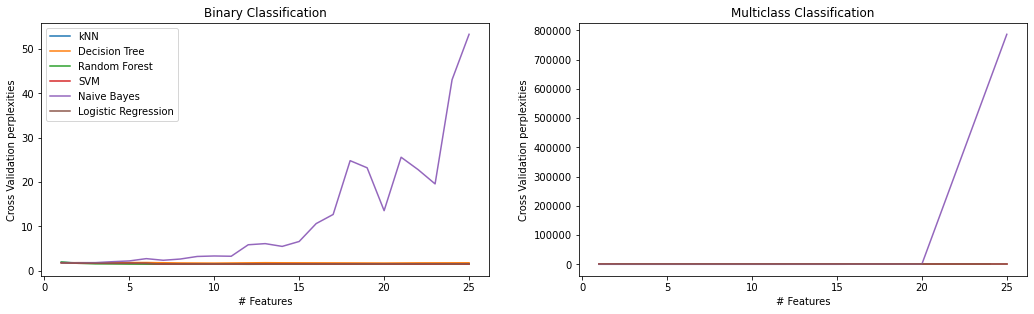

In [336]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for model in binary_perplexities.keys():
    sns.lineplot(data=binary_perplexities[model], x='# Features', y='Perplexity', ax=ax[0], label=model)
    sns.lineplot(data=multiclass_perplexities[model], x='# Features', y='Perplexity', ax=ax[1])
ax[0].legend()
ax[0].set_title('Binary Classification') 
ax[0].set_ylabel('Cross Validation perplexities')
ax[1].set_title('Multiclass Classification') 
ax[1].set_ylabel('Cross Validation perplexities')
fig.tight_layout(pad=3)
plt.show()

<Figure size 432x288 with 0 Axes>

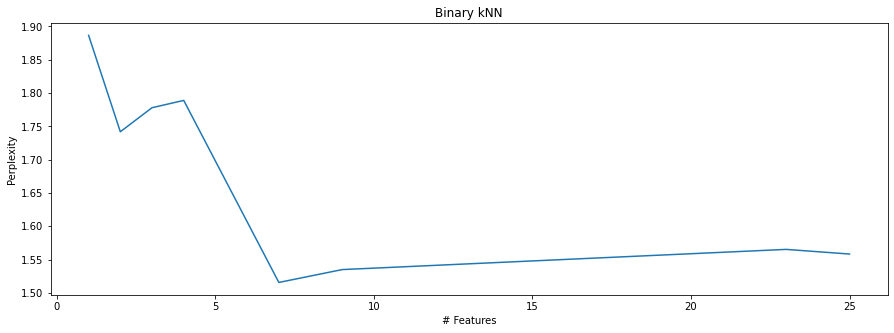

<Figure size 432x288 with 0 Axes>

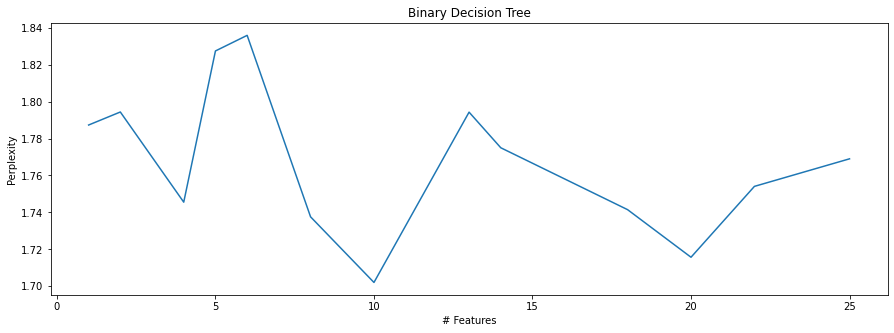

<Figure size 432x288 with 0 Axes>

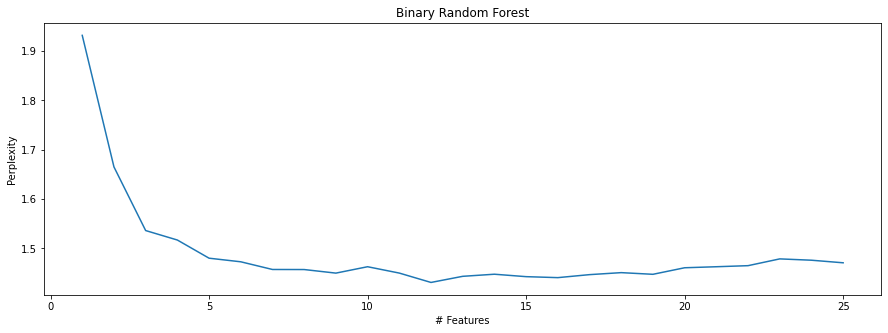

<Figure size 432x288 with 0 Axes>

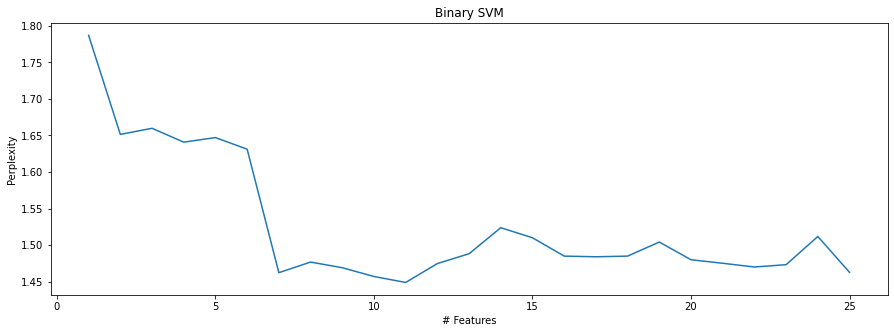

<Figure size 432x288 with 0 Axes>

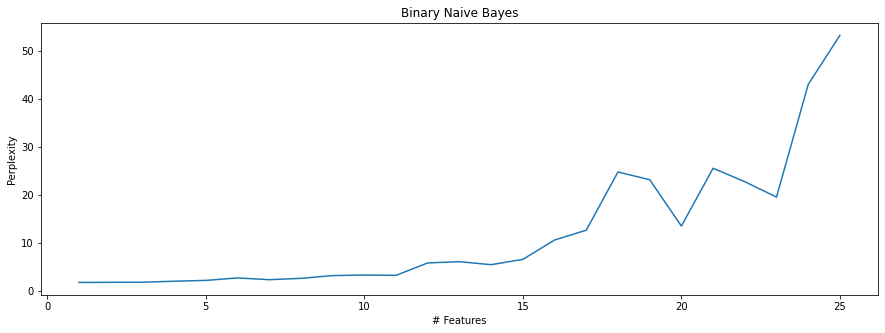

<Figure size 432x288 with 0 Axes>

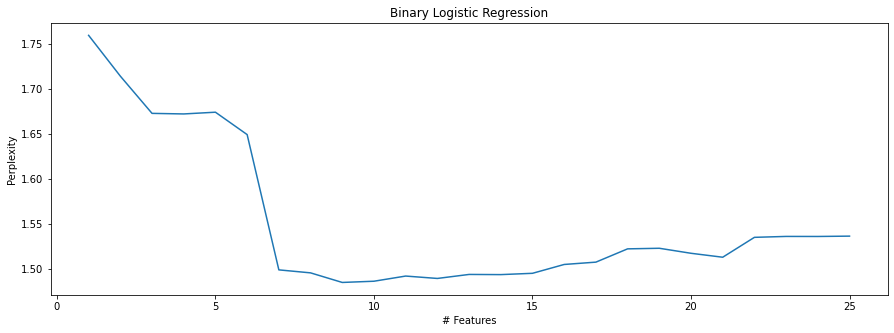

<Figure size 432x288 with 0 Axes>

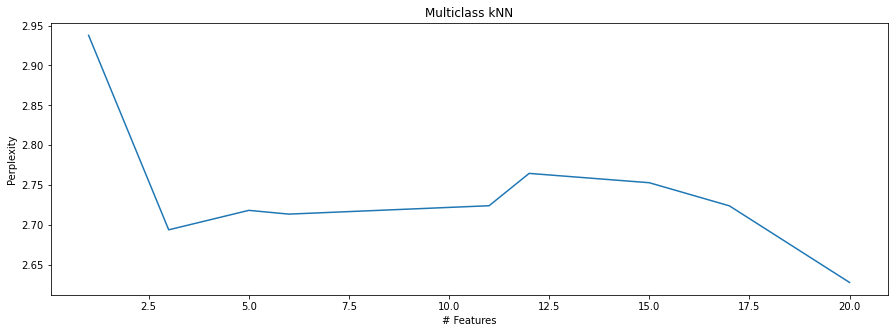

<Figure size 432x288 with 0 Axes>

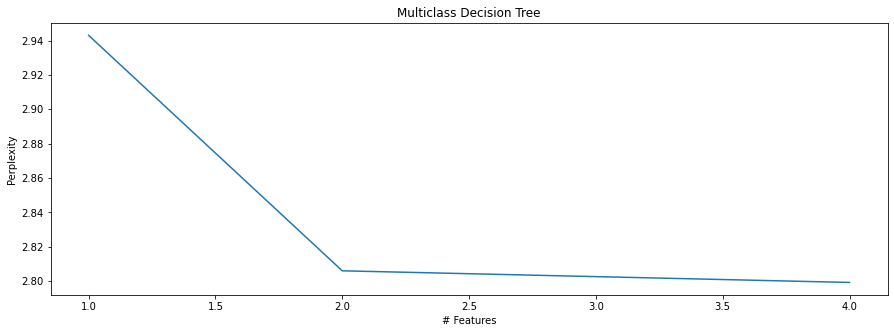

<Figure size 432x288 with 0 Axes>

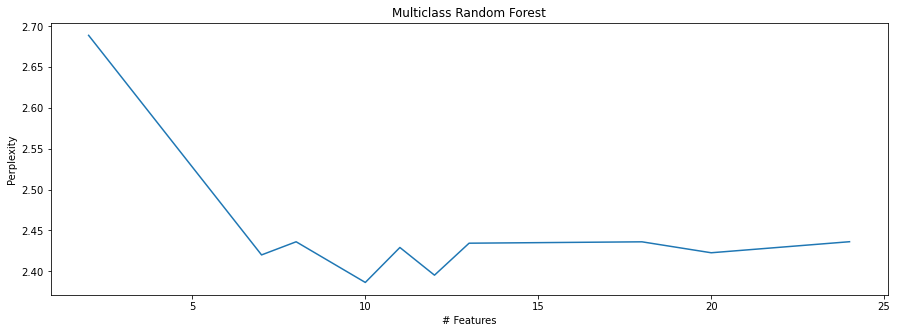

<Figure size 432x288 with 0 Axes>

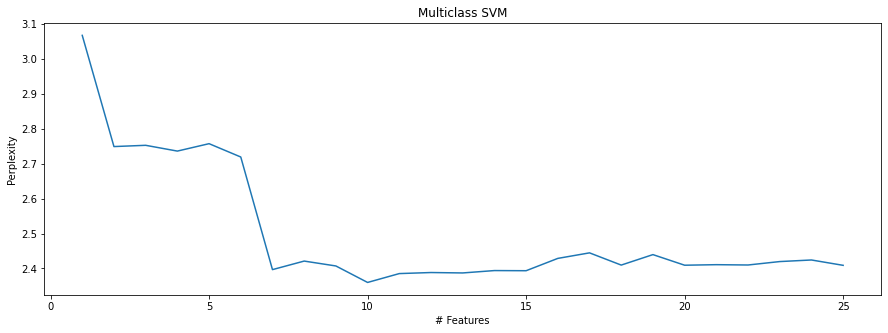

<Figure size 432x288 with 0 Axes>

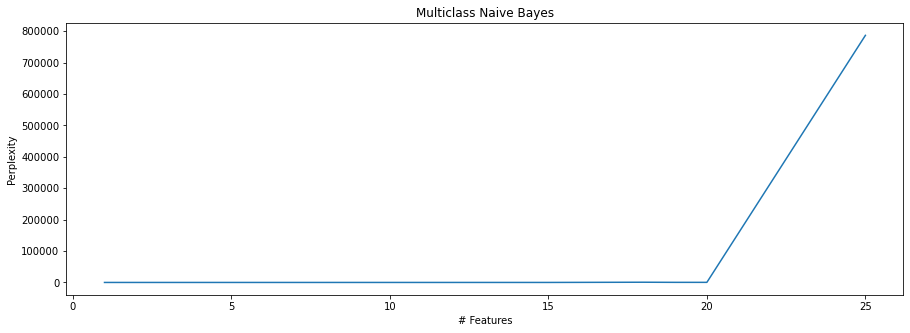

<Figure size 432x288 with 0 Axes>

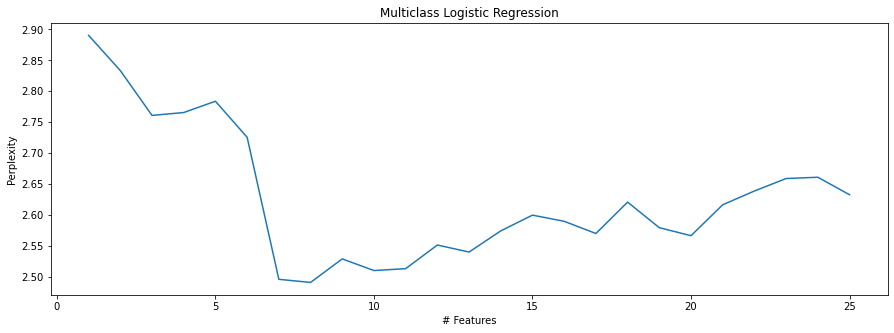

In [338]:
for model in binary_perplexities.keys():
    plt.clf()
    plt.figure(figsize=(15,5))
    sns.lineplot(data=binary_perplexities[model], x='# Features', y='Perplexity')
    plt.title('Binary ' + model)
    plt.show()
for model in multiclass_perplexities.keys():
    plt.clf()
    plt.figure(figsize=(15,5))
    sns.lineplot(data=multiclass_perplexities[model], x='# Features', y='Perplexity')
    plt.title('Multiclass ' + model)
    plt.show()

<Figure size 432x288 with 0 Axes>

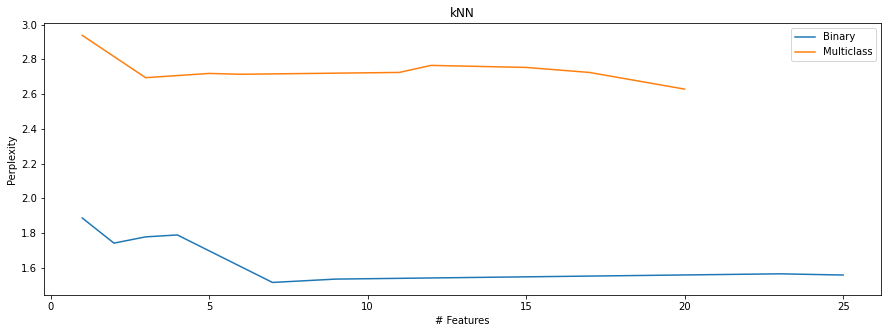

<Figure size 432x288 with 0 Axes>

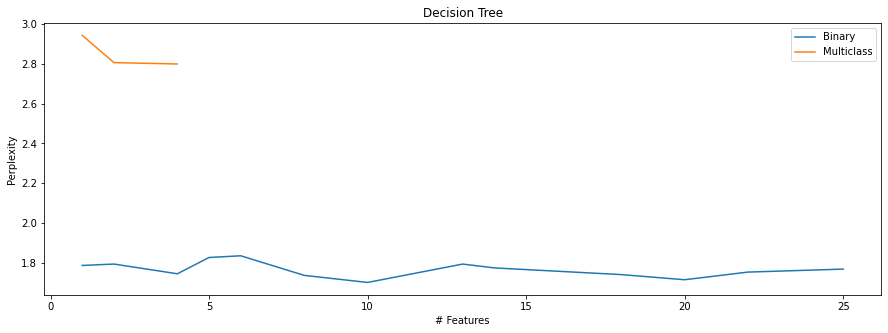

<Figure size 432x288 with 0 Axes>

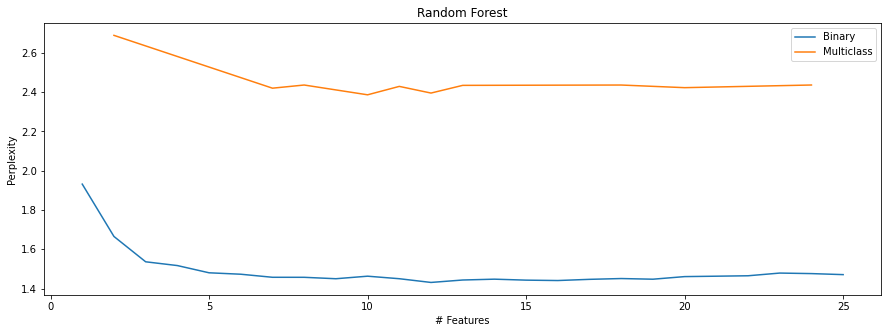

<Figure size 432x288 with 0 Axes>

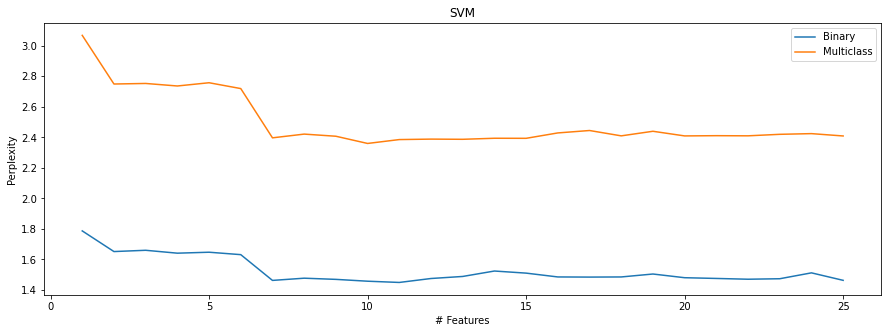

<Figure size 432x288 with 0 Axes>

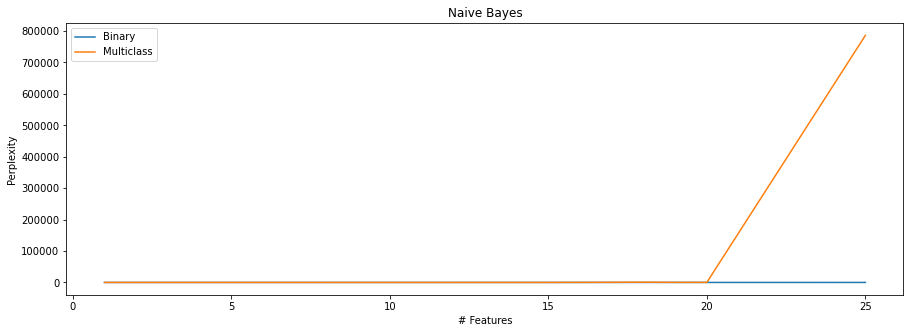

<Figure size 432x288 with 0 Axes>

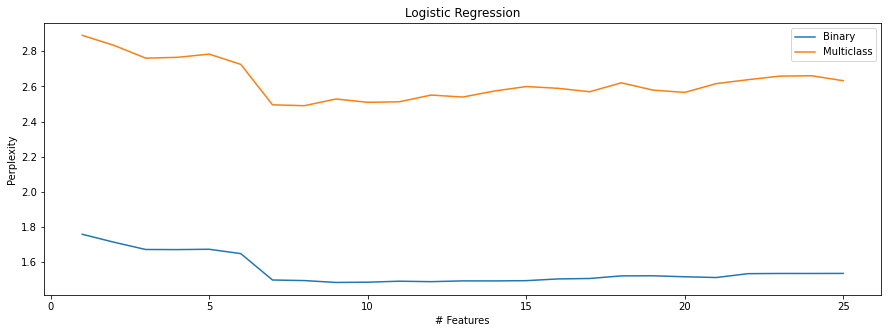

In [339]:
for model in binary_perplexities.keys():
    plt.clf()
    plt.figure(figsize=(15,5))
    sns.lineplot(data=binary_perplexities[model], x='# Features', y='Perplexity', label='Binary')
    sns.lineplot(data=multiclass_perplexities[model], x='# Features', y='Perplexity', label='Multiclass')
    plt.title(model)
    plt.show()